# Predicting Income with Social Data

### Clean and Check Data

In [33]:
# load packages and data
library(ggplot2)
library(dplyr)
library(modelr)
psid <- read.csv("psid_2017.csv")

In [34]:
#view data structure
str(psid)

'data.frame':	26445 obs. of  10 variables:
 $ X.1            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ X              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ gender         : int  2 2 2 2 1 2 2 1 2 1 ...
 $ age            : int  59 57 43 44 42 30 27 27 25 21 ...
 $ married        : int  0 0 0 0 0 1 0 0 0 0 ...
 $ employed       : Factor w/ 8 levels "disabled","employed",..: 1 2 1 NA 2 2 2 2 8 NA ...
 $ educated_in_us : int  1 1 1 9 1 1 1 1 1 0 ...
 $ highest_degree : Factor w/ 9 levels "associate","bachelor",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ education_years: int  12 12 12 99 12 12 12 12 12 0 ...
 $ labor_income   : int  0 0 0 0 0 0 0 0 0 0 ...


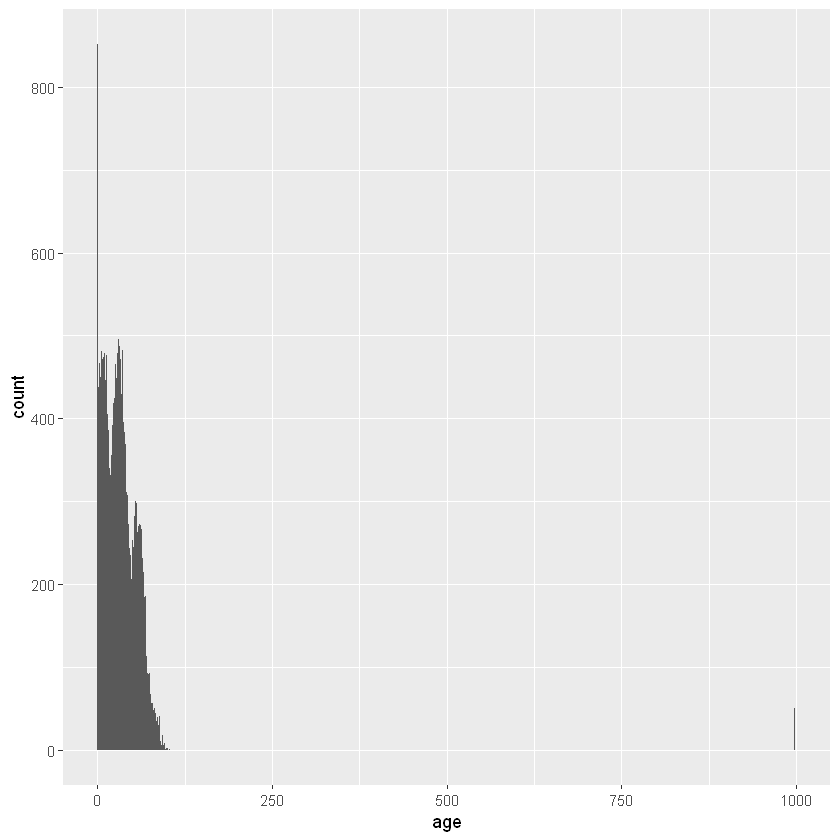

In [35]:
#plot distribution of age
age_dist <- psid %>%
  ggplot(aes(x=age)) +
  geom_bar()

#view plot
age_dist

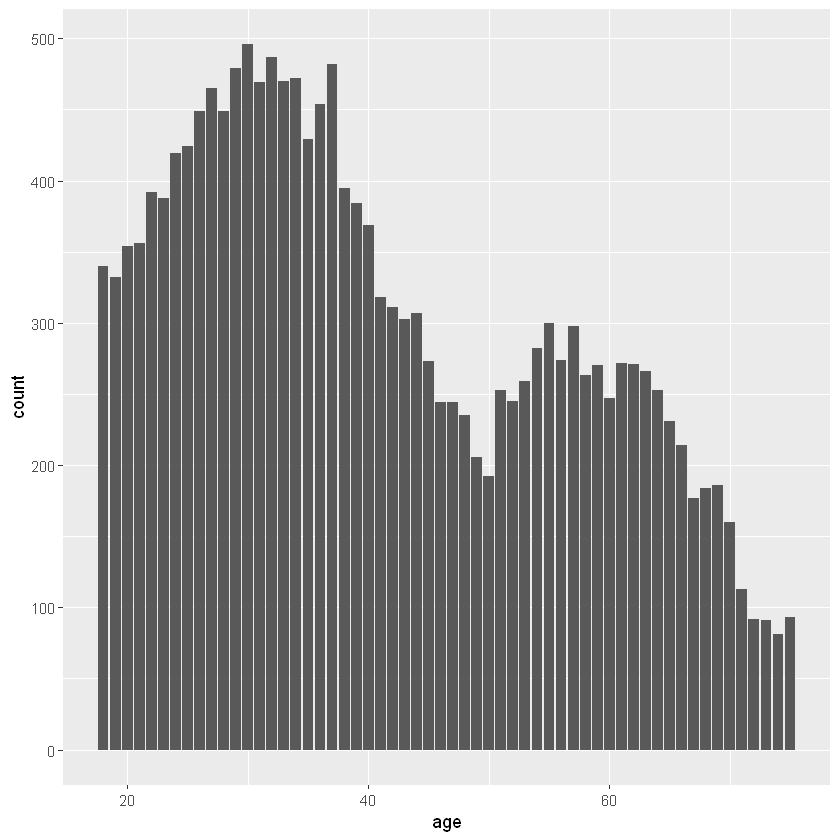

In [36]:
# filter to reasonable age group >> 18 - 75
psid_clean <- psid %>%
  filter(age>=18, age<=75)


# plot flitered age
filtered_age_dist <- psid_clean %>%
  ggplot(aes(x=age)) +
  geom_bar()

filtered_age_dist

Warning message:
"Continuous x aesthetic -- did you forget aes(group=...)?"

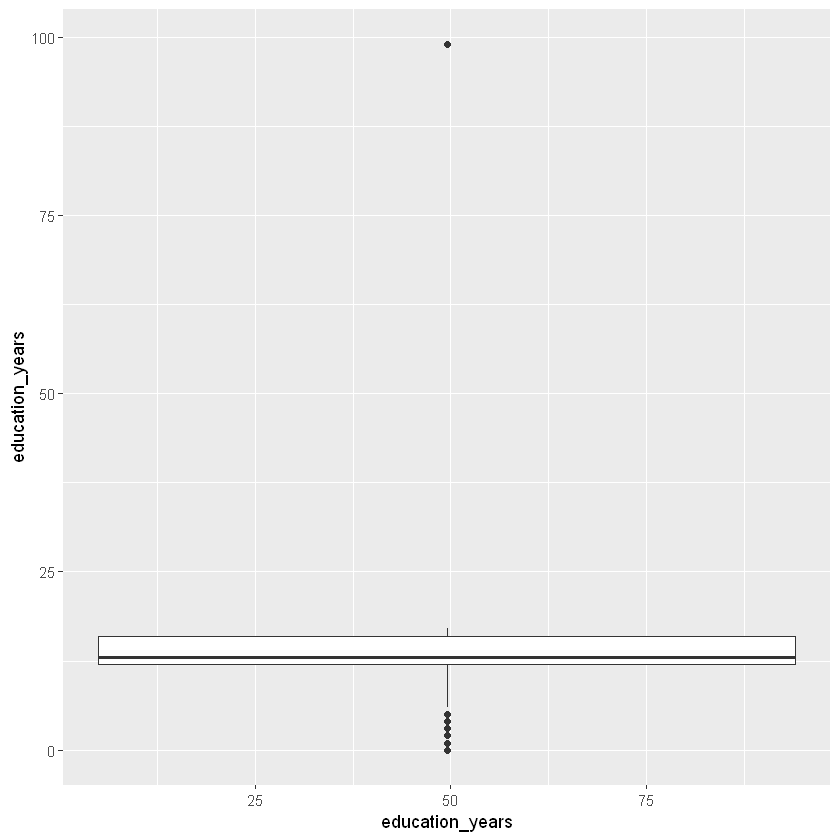

In [37]:
#plot education
edu_dist = psid_clean %>%
  ggplot(aes(x=education_years, y=education_years)) +
  geom_boxplot()

edu_dist

Warning message:
"Continuous x aesthetic -- did you forget aes(group=...)?"

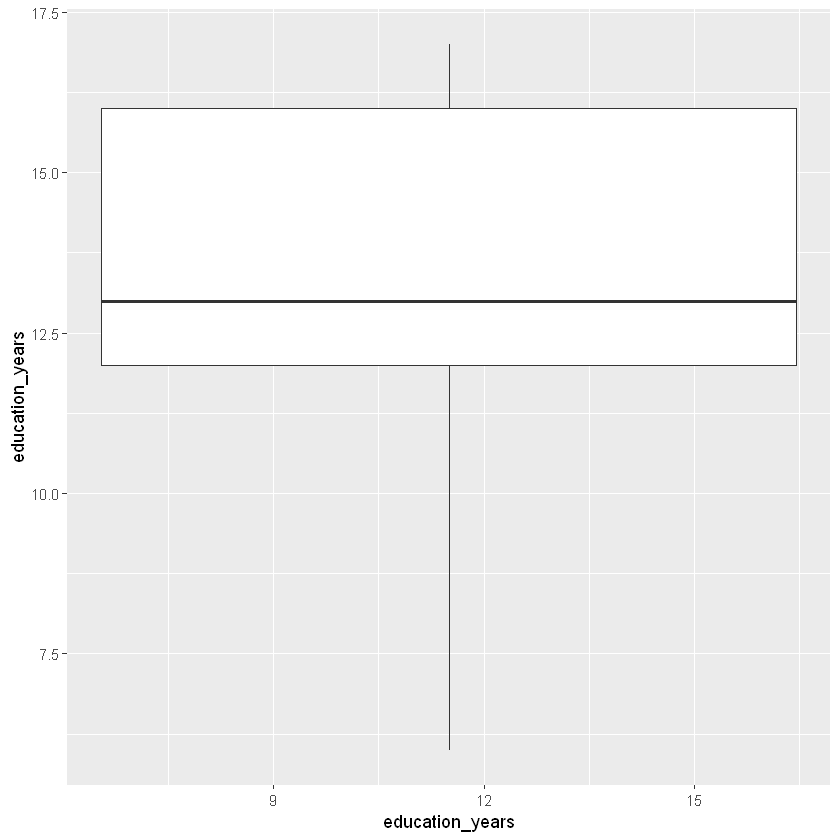

In [38]:
#filter to reasonable education levels >> 5 - 25
psid_clean <- psid_clean %>% 
  filter(education_years>5, education_years<25) 
filtered_edu_dist <-  psid_clean %>%
  ggplot(aes(x=education_years, y=education_years)) +
  geom_boxplot()

filtered_edu_dist

Warning message:
"Continuous x aesthetic -- did you forget aes(group=...)?"

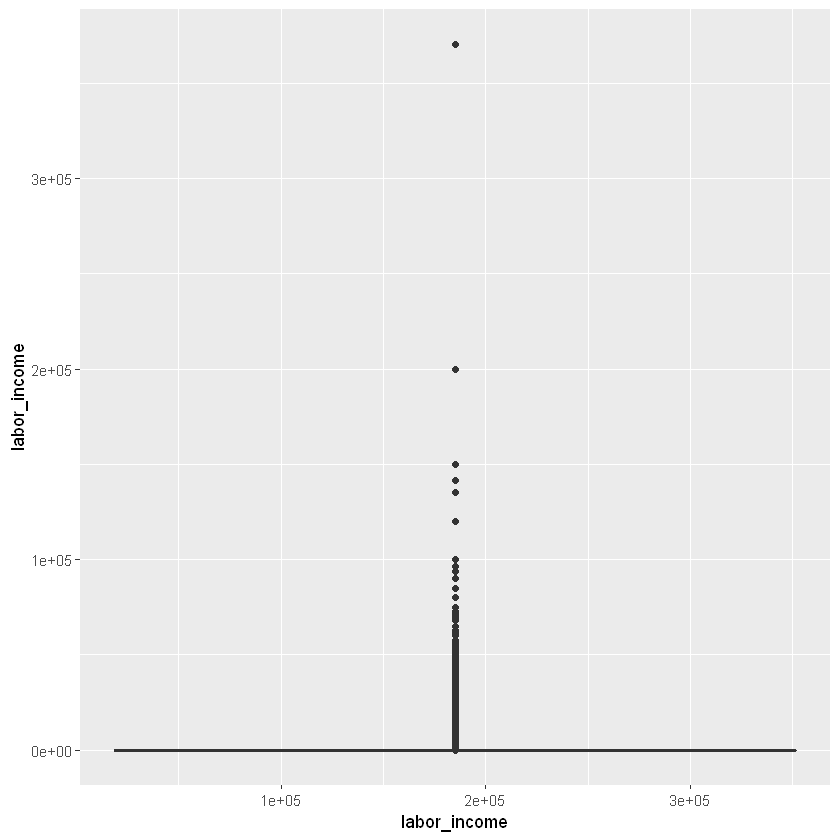

In [39]:
#plot income
income_dist <- psid_clean %>%
    ggplot(aes(labor_income, labor_income)) +
    geom_boxplot()

income_dist

In [40]:
#quantitative representation of the variable distribution
summary(psid_clean$labor_income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1770       0  370500 

##### This output tells us that the majority of observations in our dataset have no income, and that over 75% of observations (3rd Quartile) have 0 labor income.

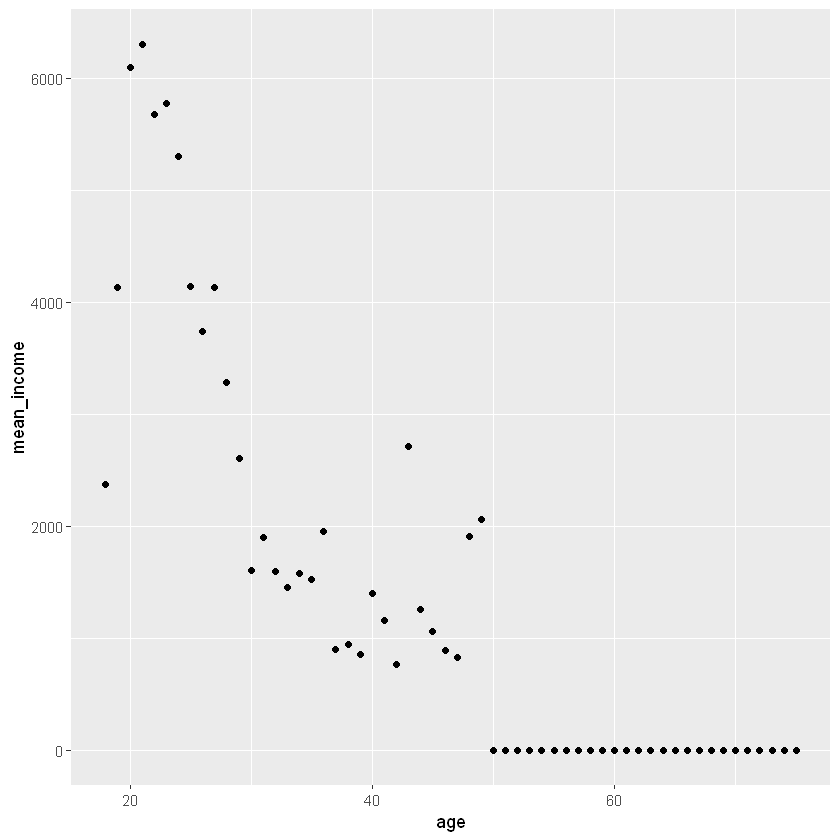

In [41]:
#plotting mean income by age
mean_income_by_age <- psid_clean %>%
    group_by(age) %>%   # group data by age
    summarise(mean_income=mean(labor_income)) %>%   # find mean income for each age group
    ggplot(aes(x=age, y=mean_income)) +
    geom_point()

mean_income_by_age

### Build Model

In [42]:
# subset data points into train and test sets

# set the seed for reproducibility
set.seed(123)

# create a sample vector with 60% TRUE and 40% FALSE values, matching the number of rows in psid
sample <- sample(c(TRUE, FALSE), nrow(psid_clean), replace=TRUE, prob=c(0.6,0.4))

# define train and test
train <- psid_clean[sample, ]
test <- psid_clean[!sample, ]

# build model
model <- lm(labor_income ~ education_years, data=train)
model


Call:
lm(formula = labor_income ~ education_years, data = train)

Coefficients:
    (Intercept)  education_years  
        2666.07           -75.24  


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


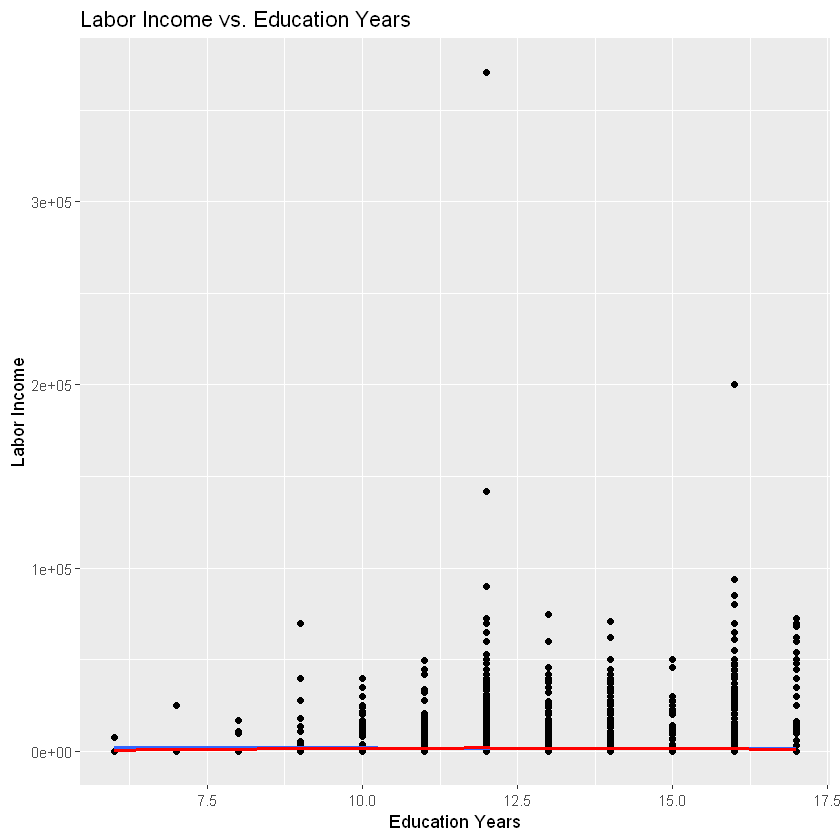

In [43]:
# plot against LOESS (locally estimated scatterplot smoothing) model
plot <- ggplot(train, aes(x=education_years, y=labor_income)) +
    geom_point() +
    geom_smooth(method = "lm") +   # add linear model smoothing
    geom_smooth(se = FALSE, color = "red") +   # add LOESS smoothing with se (standard error) bands
    labs(title = "Labor Income vs. Education Years",
        x = "Education Years",
        y = "Labor Income")

plot

In [44]:
# compute r-squared
r_sq <- summary(model)$r.squared * 100
r_sq

sprintf("Based on a simple linear regression model, we have determined that %s percent of the variation in respondent income can be predicted by a respondent's education level.", r_sq)

[1] 0.04668076

[1] "Based on a simple linear regression model, we have determined that 0.0466807630656971 percent of the variation in respondent income can be predicted by a respondent's education level."

### Build Comparison Model and Analyze Results

In [45]:
# build second model
model_2 <- lm(labor_income ~ education_years + age + gender, data=train)
model_2


Call:
lm(formula = labor_income ~ education_years + age + gender, data = train)

Coefficients:
    (Intercept)  education_years              age           gender  
        6864.23           -30.83           -94.82          -580.65  


In [46]:
# compute r-squared
r_sq_2 <- summary(model_2)$r.squared * 100
r_sq_2
sprintf("Based on a simple linear regression model, we have determined that %s percent of the variation in respondent income can be predicted by a respondent's education level, age and gender.", r_sq_2)

[1] 3.479771

[1] "Based on a simple linear regression model, we have determined that 3.47977088972275 percent of the variation in respondent income can be predicted by a respondent's education level, age and gender."

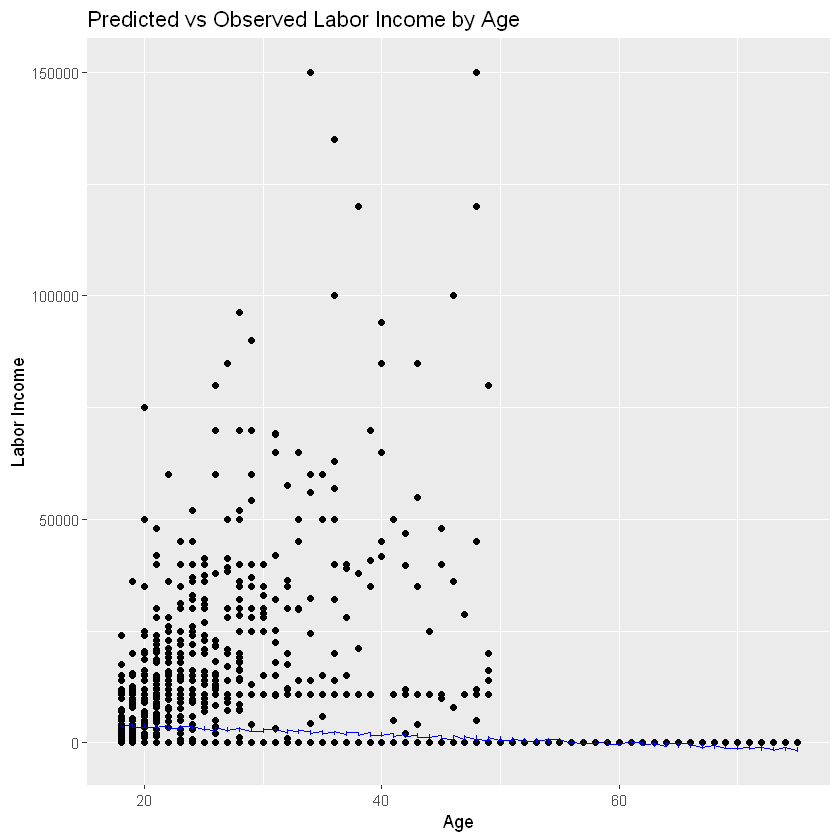

In [47]:
# representation of model_2 fit
# plot predictions versus observed

plot <- test %>%
    add_predictions(model_2) %>%
    ggplot(aes(x=age, y=labor_income)) + 
    geom_point() +   # scatter plot of observed values
    geom_line(aes(y=pred), color="blue") +   # line plot of predicted values
    labs(title = "Predicted vs Observed Labor Income by Age",
       x = "Age",
       y = "Labor Income")
plot

In [48]:
summary(model_2)


Call:
lm(formula = labor_income ~ education_years + age + gender, data = train)

Residuals:
   Min     1Q Median     3Q    Max 
 -4361  -2519  -1459     88 368664 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     6864.231    552.257  12.429  < 2e-16 ***
education_years  -30.829     34.792  -0.886 0.375583    
age              -94.819      5.218 -18.171  < 2e-16 ***
gender          -580.648    157.822  -3.679 0.000235 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7755 on 9750 degrees of freedom
Multiple R-squared:  0.0348,	Adjusted R-squared:  0.0345 
F-statistic: 117.2 on 3 and 9750 DF,  p-value: < 2.2e-16


 ##### All variables are highly significant, with a p-value < 0.01.
 ##### The gender coefficient represents the effect of changing the gender of the respondent to woman.